# 01_data_raw

## 1️⃣ Loading raw wine production data

In this notebook, we will:

1. Load the raw wine production data per municipality (Excel file).
2. Inspect the first few rows to verify correctness.
3. Save the dataset as CSV for easier processing in later steps.

Once the raw data is prepared, we will also incorporate the **administrative boundaries of municipalities** in Alentejo from the Official Administrative Map of Portugal (CAOP).  
This will allow us to merge production data with geographic boundaries for spatial analysis and visualization later on.



In [80]:
import pandas as pd
from pathlib import Path
from IPython.display import display
import logging

# -----------------------------
# Logging setup
# -----------------------------
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# -----------------------------
# Column definitions
# -----------------------------
total_columns = ['TotalWine_Red', 'TotalWine_Rose', 'TotalWine_White', 'TotalWine_General']
columns_of_interest = ['Distrito', 'Concelho'] + total_columns

expected_columns = [
    'Distrito', 'Concelho',
    'Vinho_Tinto', 'Vinho_Rosado', 'Vinho_Branco', 'Vinho_Total',
    'IndCasta_Tinto', 'IndCasta_Rosado', 'IndCasta_Branco', 'IndCasta_Total',
    'IGP_Tinto', 'IGP_Rosado', 'IGP_Branco', 'IGP_Total',
    'LicorosoDOP_Tinto', 'LicorosoDOP_Rosado', 'LicorosoDOP_Branco', 'LicorosoDOP_Total',
    'DOP_Tinto', 'DOP_Rosado', 'DOP_Branco', 'DOP_Total',
    'TotalWine_Red', 'TotalWine_Rose', 'TotalWine_White', 'TotalWine_General'
]

# -----------------------------
# Functions
# -----------------------------
def read_excel(file_path: str, sheet_index: int) -> pd.DataFrame:
    """Read Excel sheet and return DataFrame."""
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_index, header=None)
        logging.info(f"Excel sheet {sheet_index} read successfully from {file_path}")
        return df
    except Exception as e:
        logging.error(f"Error reading Excel file: {e}")
        raise

def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Rename columns to expected names."""
    if len(df.columns) != len(expected_columns):
        raise ValueError(f"Expected {len(expected_columns)} columns, found {len(df.columns)}")
    df.columns = expected_columns
    logging.info("Columns renamed successfully")
    return df

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and format data for municipalities."""
    df_clean = df[columns_of_interest].copy()
    df_clean = df_clean.dropna(how='all')
    df_clean = df_clean[~df_clean['Distrito'].astype(str).str.contains('Produção|Total|Distrito', na=False)]
    df_clean['Distrito'] = df_clean['Distrito'].ffill()
    df_clean = df_clean[df_clean['Concelho'].notna()].reset_index(drop=True)
    
    # Convert totals to int
    for col in total_columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0).round(0).astype(int)
    
    logging.info("Data cleaned and formatted successfully")
    return df_clean

def save_to_csv(df: pd.DataFrame, output_path: str):
    """Save DataFrame to CSV."""
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path, index=False, encoding='utf-8')
    logging.info(f"CSV saved successfully at {output_path}")

def display_table(df: pd.DataFrame, rows: int = 10, caption: str = "Table"):
    """Display first rows of DataFrame in Jupyter."""
    display(df.head(rows).style.set_caption(caption))



In [81]:
input_path = r"C:\Users\islec\climate-wine-project\data_raw\wine_production_raw.xlsx"
output_concelho = r"C:\Users\islec\climate-wine-project\data_clean\wine_production_concelho.csv"

df = read_excel(input_path, sheet_index=22)
df = rename_columns(df)
df_clean_concelho = clean_data(df)
save_to_csv(df_clean_concelho, output_concelho)

display_table(df_clean_concelho, rows=10, caption="Wine Production by Municipality")
logging.info("CSV by Municipality generated successfully.")
logging.info(f"File saved at: {output_concelho}")


INFO: Excel sheet 22 read successfully from C:\Users\islec\climate-wine-project\data_raw\wine_production_raw.xlsx
INFO: Columns renamed successfully
INFO: Data cleaned and formatted successfully
INFO: CSV saved successfully at C:\Users\islec\climate-wine-project\data_clean\wine_production_concelho.csv


,Distrito,Concelho,TotalWine_Red,TotalWine_Rose,TotalWine_White,TotalWine_General
0,Aveiro,Águeda,1362,1666,3432,6459
1,Aveiro,Albergaria-a-Velha,223,21,265,509
2,Aveiro,Anadia,29328,35995,34513,99837
3,Aveiro,Arouca,95,0,267,363
4,Aveiro,Aveiro,62,0,18,80
5,Aveiro,Castelo de Paiva,5354,86,14811,20250
6,Aveiro,Estarreja,14,6,21,41
7,Aveiro,Ílhavo,18,11,0,29
8,Aveiro,Mealhada,4015,1618,4522,10155
9,Aveiro,Oliveira de Azeméis,0,0,8,8


INFO: CSV by Municipality generated successfully.
INFO: File saved at: C:\Users\islec\climate-wine-project\data_clean\wine_production_concelho.csv


In [83]:
# -----------------------------
# File path for district totals
# -----------------------------
output_district = r"C:\Users\islec\climate-wine-project\data_clean\wine_production_by_district.csv"

# -----------------------------
# Aggregate by district and save
# -----------------------------
df_clean_district = save_district_totals(
    df_clean_concelho.groupby('Distrito')[total_columns].sum().reset_index(),
    output_district
)

# -----------------------------
# Logging and display
# -----------------------------
display_table(df_clean_district, rows=10, caption="Wine Production by District")
logging.info("CSV with totals by District generated successfully.")
logging.info(f"File saved at: {output_district}")


,Distrito,TotalWine_Red,TotalWine_Rose,TotalWine_White,TotalWine_General
0,Aveiro,44550,40519,65022,150092
1,Açores,1413,209,2042,3663
2,Beja,154990,7766,72344,235101
3,Braga,37130,12934,208243,258308
4,Bragança,121182,43836,27664,192683
5,Castelo Branco,9499,132,2111,11742
6,Coimbra,20769,6870,25629,53268
7,Faro,10750,2806,7603,21156
8,Guarda,342219,20795,87595,450612
9,Leiria,62236,6978,27971,97183


INFO: CSV with totals by District generated successfully.
INFO: File saved at: C:\Users\islec\climate-wine-project\data_clean\wine_production_by_district.csv


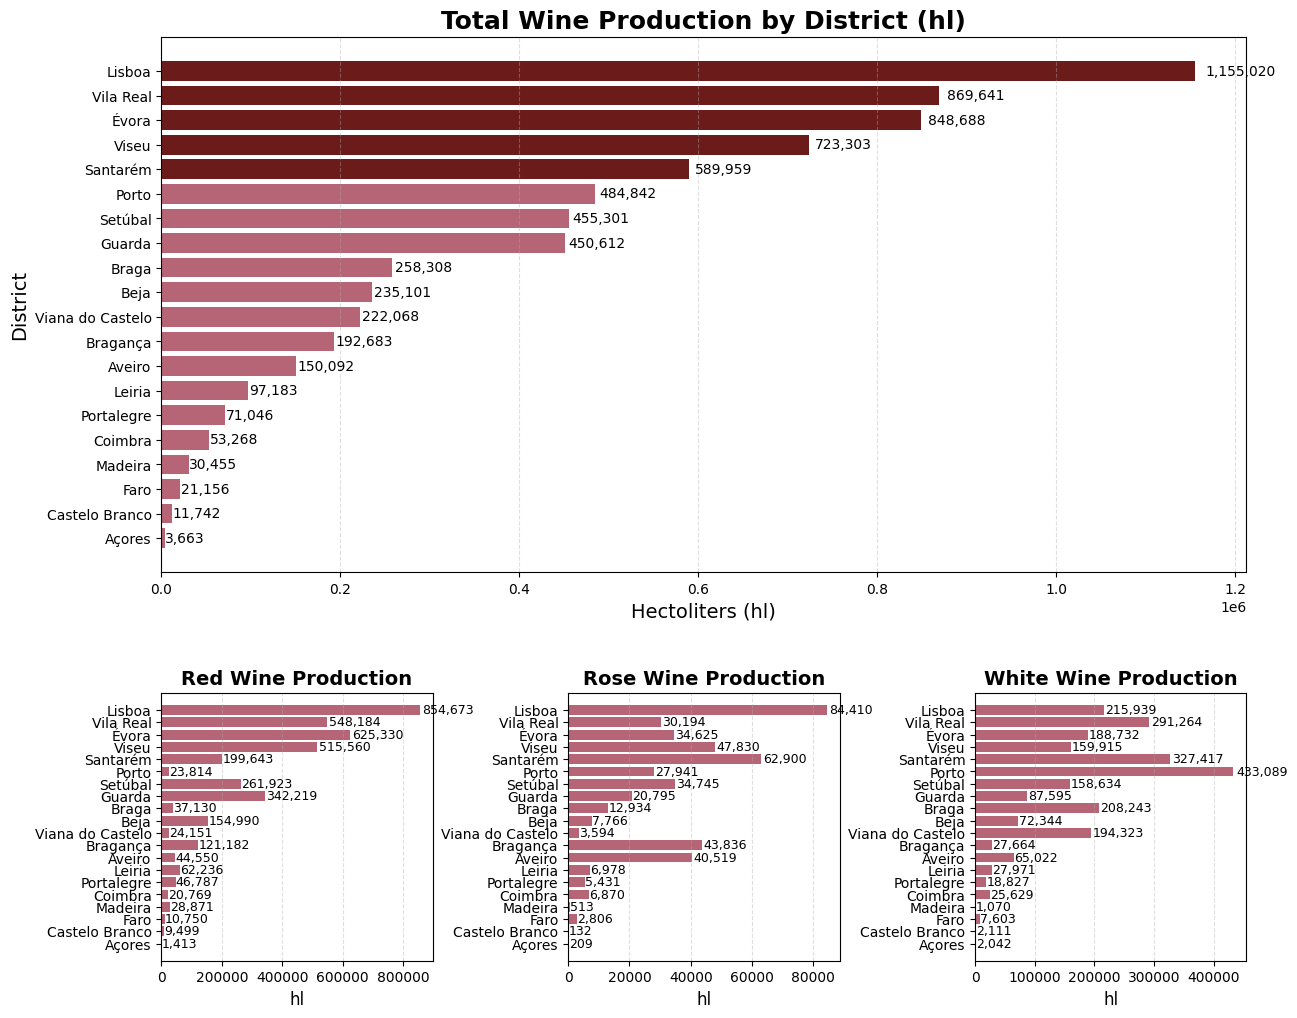

INFO: All charts generated and saved successfully.
INFO: Chart saved at: C:\Users\islec\climate-wine-project\data_viz\wine_total_by_district.png


In [84]:
# -----------------------------
# Create combined chart: TotalWine_General + individual wine types
# -----------------------------

# Sort districts by total wine production
df_plot = df_clean_district.sort_values('TotalWine_General', ascending=True)

# Define wine types for smaller charts
wine_types = ['TotalWine_Red', 'TotalWine_Rose', 'TotalWine_White']

# Create figure with gridspec: 2 rows (big chart + 3 small charts)
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(2, 3, height_ratios=[2, 1], hspace=0.3, wspace=0.5)

# -----------------------------
# Main chart: TotalWine_General
# -----------------------------
ax_main = fig.add_subplot(gs[0, :])
colors_main = ['#6a1b1a' if i >= len(df_plot)-5 else '#b56576' for i in range(len(df_plot))]
bars_main = ax_main.barh(df_plot['Distrito'], df_plot['TotalWine_General'], color=colors_main)

ax_main.set_title("Total Wine Production by District (hl)", fontsize=18, fontweight='bold')
ax_main.set_xlabel("Hectoliters (hl)", fontsize=14)
ax_main.set_ylabel("District", fontsize=14)
ax_main.grid(axis='x', linestyle='--', alpha=0.4)

# Add value labels
for bar in bars_main:
    ax_main.text(bar.get_width() * 1.01, bar.get_y() + bar.get_height()/2,
                 f"{bar.get_width():,.0f}", va='center', fontsize=10)

# -----------------------------
# Smaller charts: Red, Rose, White
# -----------------------------
for i, wine in enumerate(wine_types):
    ax = fig.add_subplot(gs[1, i])
    bars = ax.barh(df_plot['Distrito'], df_plot[wine], color='#b56576')
    ax.set_title(f"{wine.replace('TotalWine_', '')} Wine Production", fontsize=14, fontweight='bold')
    ax.set_xlabel("hl", fontsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.4)
    
    # Add value labels
    for bar in bars:
        ax.text(bar.get_width() * 1.01, bar.get_y() + bar.get_height()/2,
                f"{bar.get_width():,.0f}", va='center', fontsize=9)

# -----------------------------
# Save figure
# -----------------------------
viz_path = Path(r"C:\Users\islec\climate-wine-project\data_viz\wine_total_by_district.png")
viz_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
plt.show()
# -----------------------------
# Status message
# -----------------------------
logging.info("All charts generated and saved successfully.")
logging.info(f"Chart saved at: {viz_path}")



In [85]:
import matplotlib.pyplot as plt
from pathlib import Path
import logging

# -----------------------------
# Configurações iniciais
# -----------------------------
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Lista de colunas de total de vinho
total_columns = ['TotalWine_Red', 'TotalWine_Rose', 'TotalWine_White', 'TotalWine_General']
wine_types = total_columns[:-1]  # apenas tipos individuais: Red, Rose, White

# Pasta para salvar gráficos
output_dir_viz = Path(r"C:\Users\islec\climate-wine-project\data_viz\wine_district_charts")
output_dir_viz.mkdir(parents=True, exist_ok=True)

saved_files = []  # armazenar caminhos dos arquivos salvos

# -----------------------------
# Calcular totais por distrito
# -----------------------------
district_totals = df_clean.groupby('Distrito')[total_columns].sum()
top_distritos = district_totals['TotalWine_General'].nlargest(3).index  # top 3

# -----------------------------
# Função para criar gráfico de um distrito
# -----------------------------
def plot_district(df_dist, distrito, save_path=None):
    df_plot = df_dist.sort_values('TotalWine_General', ascending=True)
    if df_plot.empty:
        logging.warning(f"No data for district {distrito}, skipping.")
        return None
    
    num_concelhos = len(df_plot)
    fig, ax = plt.subplots(figsize=(12, max(4, num_concelhos * 0.4)))
    
    bars = ax.barh(df_plot['Concelho'], df_plot['TotalWine_General'], color='#6a1b1a')
    
    ax.set_title(f"Wine Production - {distrito}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Hectoliters (hl)")
    ax.set_ylabel("Concelho")
    ax.grid(axis='x', linestyle='--', alpha=0.4)
    
    # Adicionar valores nas barras
    for bar in bars:
        width = bar.get_width()
        ax.text(width + max(df_plot['TotalWine_General']) * 0.01,
                bar.get_y() + bar.get_height()/2,
                f"{width:,.0f}", va='center', fontsize=8)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved chart for {distrito} at {save_path}")
        plt.close()
        return save_path
    else:
        plt.show()
        plt.close()
        return None

# -----------------------------
# Gerar gráficos para todos os distritos
# -----------------------------
for distrito, df_dist in df_clean.groupby('Distrito'):
    safe_name = "".join(c if c.isalnum() else "_" for c in distrito)
    viz_path = output_dir_viz / f"{safe_name}.png"
    saved_file = plot_district(df_dist, distrito, save_path=viz_path)
    if saved_file:
        saved_files.append(saved_file)

# -----------------------------
# Mostrar apenas os top 3 distritos
# -----------------------------
for distrito in top_distritos:
    df_dist = df_clean[df_clean['Distrito'] == distrito]
    plot_district(df_dist, distrito, save_path=None)

# -----------------------------
# Status final
# -----------------------------
logging.info("All district charts generated and saved successfully.")
logging.info(f"Charts saved in folder: {output_dir_viz}")

print("\nSaved files:")
for f in saved_files:
    print(f"- {f}")



KeyError: "Columns not found: 'TotalWine_White', 'TotalWine_General', 'TotalWine_Red', 'TotalWine_Rose'"

## 2️⃣ Loading Municipal Boundaries (CAOP)

So far, we have loaded and processed the wine production data per municipality.  
To complement our analysis and enable geographic visualizations, we will now import the **administrative boundaries of municipalities** in Alentejo from the Official Administrative Map of Portugal (CAOP).  

This step will allow us to:

- Filter only the municipalities in Alentejo.
- Merge the wine production data with geographic boundaries.
- Create maps and perform spatial analyses later on.

By doing this, our dataset will be complete and ready for more advanced analysis and visualizations.



<Figure size 1200x1200 with 0 Axes>

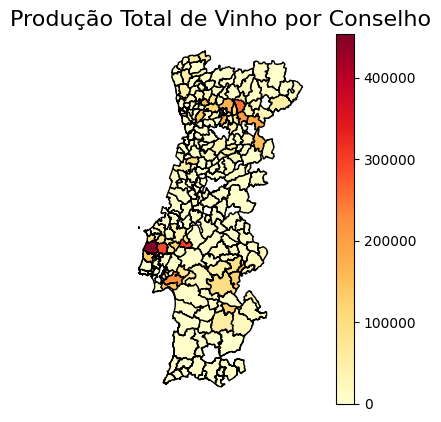

<Figure size 1200x1200 with 0 Axes>

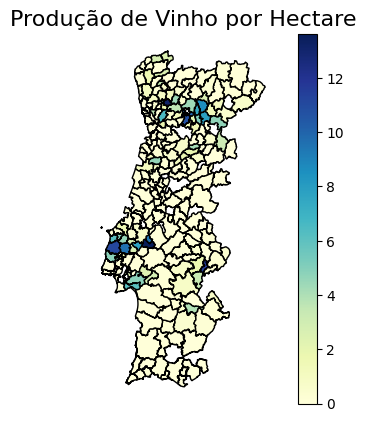

✅ Mapas salvos em data_viz!


In [36]:
# 📌 Notebook enxuto - Produção de Vinho em Alentejo

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Carregar GeoDataFrame dos municípios/concelhos
# -----------------------------
munis = gpd.read_file(
    r"C:\Users\islec\climate-wine-project\data_raw\Portugal_conselhos.gpkg", 
    layer="cont_municipios"
)

# -----------------------------
# 2️⃣ Carregar CSV de produção por concelho
# -----------------------------
wine_data = pd.read_csv(
    r"C:\Users\islec\climate-wine-project\data_clean\wine_production_concelho.csv"
)

# -----------------------------
# 3️⃣ Merge entre dados geográficos e produção
# -----------------------------
# GeoPackage: 'municipio', CSV: 'Concelho'
munis_wine = munis.merge(
    wine_data, 
    left_on="municipio", 
    right_on="Concelho", 
    how='left'
)

# -----------------------------
# 4️⃣ Mapas de produção
# -----------------------------

# 4a️⃣ Produção total por município (escala linear)
plt.figure(figsize=(12,12))
munis_wine.plot(
    column='TotalGeral_Total',  
    cmap='YlOrRd',
    legend=True,
    edgecolor='black'
)
plt.title("Produção Total de Vinho por Conselho", fontsize=16)
plt.axis('off')
plt.show()

# 4b️⃣ Produção por hectare (eficiência)
munis_wine['Prod_por_ha'] = munis_wine['TotalGeral_Total'] / munis_wine['area_ha']

plt.figure(figsize=(12,12))
munis_wine.plot(
    column='Prod_por_ha',  
    cmap='YlGnBu',
    legend=True,
    edgecolor='black'
)
plt.title("Produção de Vinho por Hectare", fontsize=16)
plt.axis('off')
plt.show()
# -----------------------------
# 5️⃣ Salvar mapas como imagens no data_viz
# -----------------------------
import os

# Criar pasta se não existir
output_map_dir = r"C:\Users\islec\climate-wine-project\data_viz"
os.makedirs(output_map_dir, exist_ok=True)

# Dicionário com mapas e colunas
mapas = {
    "Producao_Total": "TotalGeral_Total",
    "Producao_por_ha": "Prod_por_ha"
}

for nome, coluna in mapas.items():
    fig, ax = plt.subplots(figsize=(12,12))
    munis_wine.plot(
        column=coluna,
        cmap='YlOrRd' if coluna=="TotalGeral_Total" else 'YlGnBu',
        legend=True,
        edgecolor='black',
        ax=ax
    )
    ax.set_title(nome.replace("_", " "), fontsize=16)
    ax.axis('off')
    # Salvar no data_viz
    fig.savefig(os.path.join(output_map_dir, f"{nome}.png"), dpi=300)
    plt.close(fig)

print("✅ Mapas salvos em data_viz!")



<Figure size 1200x1200 with 0 Axes>

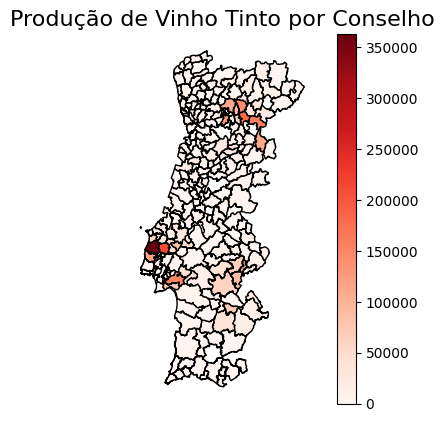

<Figure size 1200x1200 with 0 Axes>

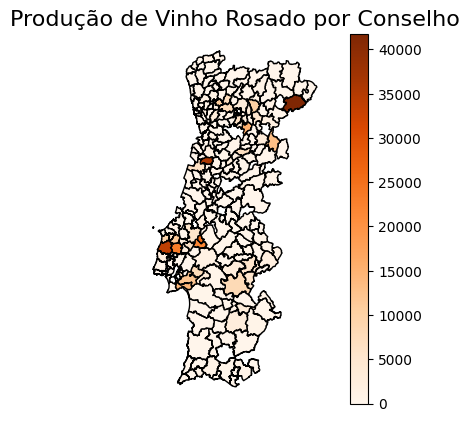

<Figure size 1200x1200 with 0 Axes>

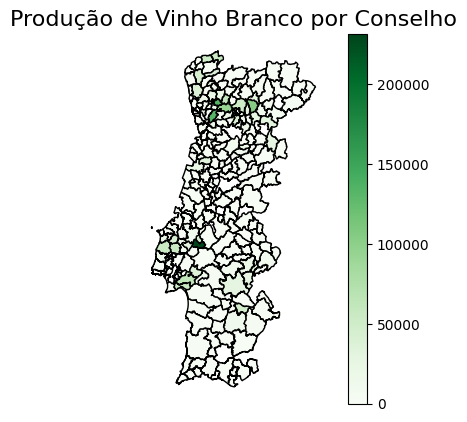

✅ Mapas de tinto, rosado e branco salvos em data_viz!


In [37]:
# 📌 Notebook enxuto - Produção de Vinho em Alentejo (Total + Tipos)

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Carregar GeoDataFrame dos municípios/concelhos
# -----------------------------
munis = gpd.read_file(
    r"C:\Users\islec\climate-wine-project\data_raw\Portugal_conselhos.gpkg", 
    layer="cont_municipios"
)

# -----------------------------
# 2️⃣ Carregar CSV de produção por concelho
# -----------------------------
wine_data = pd.read_csv(
    r"C:\Users\islec\climate-wine-project\data_clean\wine_production_concelho.csv"
)

# -----------------------------
# 3️⃣ Merge entre dados geográficos e produção
# -----------------------------
munis_wine = munis.merge(
    wine_data, 
    left_on="municipio", 
    right_on="Concelho", 
    how='left'
)

# -----------------------------
# 4️⃣ Mapas de produção
# -----------------------------

# 4c️⃣ Produção por tipo de vinho
tipos = ['TotalGeral_Tinto', 'TotalGeral_Rosado', 'TotalGeral_Branco']
cmap_dict = {'TotalGeral_Tinto':'Reds', 'TotalGeral_Rosado':'Oranges', 'TotalGeral_Branco':'Greens'}

for tipo in tipos:
    plt.figure(figsize=(12,12))
    munis_wine.plot(
        column=tipo,
        cmap=cmap_dict[tipo],
        legend=True,
        edgecolor='black'
    )
    plt.title(f"Produção de Vinho {tipo.split('_')[-1]} por Conselho", fontsize=16)
    plt.axis('off')
    plt.show()
    # -----------------------------
# 5️⃣ Salvar mapas por tipo de vinho no data_viz
# -----------------------------
import os

output_map_dir = r"C:\Users\islec\climate-wine-project\data_viz"
os.makedirs(output_map_dir, exist_ok=True)

for tipo in tipos:
    fig, ax = plt.subplots(figsize=(12,12))
    munis_wine.plot(
        column=tipo,
        cmap=cmap_dict[tipo],
        legend=True,
        edgecolor='black',
        ax=ax
    )
    ax.set_title(f"Produção de Vinho {tipo.split('_')[-1]} por Conselho", fontsize=16)
    ax.axis('off')
    # Salvar no data_viz
    fig.savefig(os.path.join(output_map_dir, f"{tipo}.png"), dpi=300)
    plt.close(fig)

print("✅ Mapas de tinto, rosado e branco salvos em data_viz!")



=== National Wine Production ===
TotalGeral_Tinto     3933674
TotalGeral_Rosado     475028
TotalGeral_Branco    2515434
TotalGeral_Total     6924131
dtype: int64

Percentage of each type:
TotalGeral_Tinto     28.41
TotalGeral_Rosado     3.43
TotalGeral_Branco    18.16
TotalGeral_Total     50.00
dtype: float64

=== Descriptive Statistics per Type ===


,count,mean,std,min,25%,50%,75%,max,percentage_of_total
TotalGeral_Tinto,272.0,14462.036765,38517.765299,0.0,83.0,1150.0,7242.75,362592.0,56.811086
TotalGeral_Rosado,272.0,1746.426471,5112.900127,0.0,0.0,57.5,767.50,41746.0,6.860471
TotalGeral_Branco,272.0,9247.919118,23227.975522,0.0,55.0,538.0,6480.75,231591.0,36.328515
TotalGeral_Total,272.0,25456.363971,56525.565857,0.0,177.5,2208.0,19658.75,453524.0,100.000000


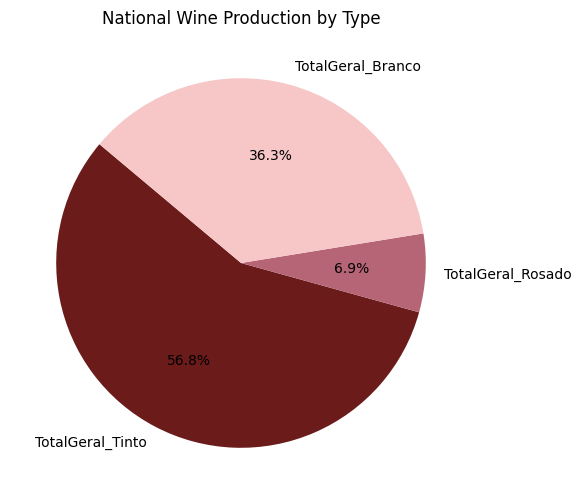

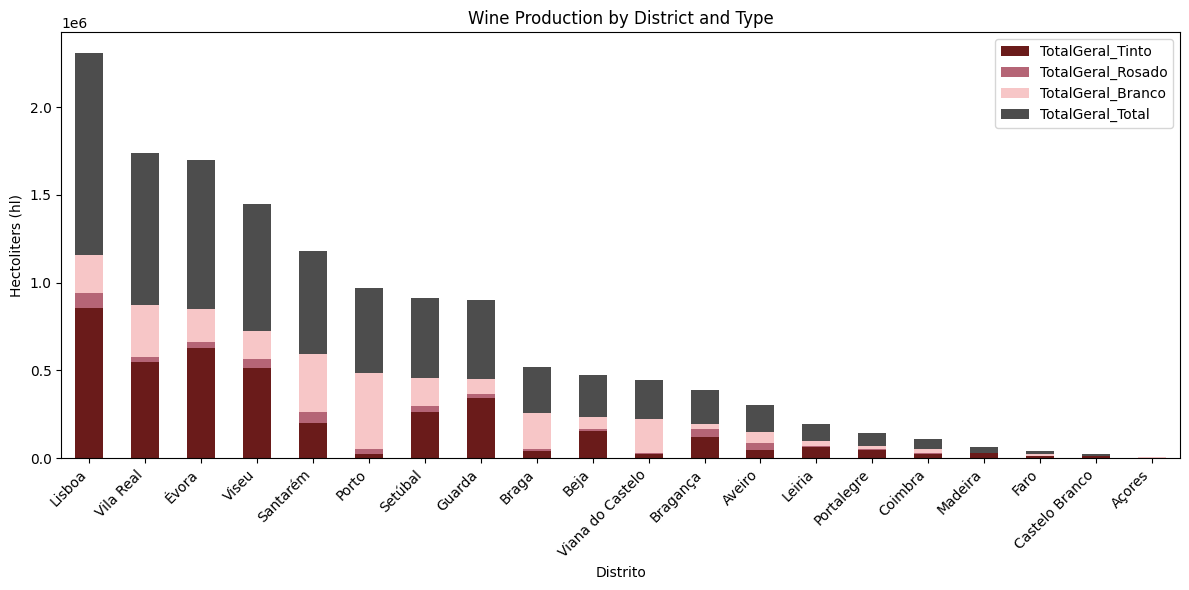

INFO: National summary charts saved in C:\Users\islec\climate-wine-project\data_viz\national_summary


In [61]:
# Define folder to save visuals
output_dir_viz = Path(r"C:\Users\islec\climate-wine-project\data_viz\national_summary")
output_dir_viz.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Total production per type
# -----------------------------
totals_national = df_clean[total_columns].sum()
percentages = totals_national / totals_national.sum() * 100

print("=== National Wine Production ===")
print(totals_national)
print("\nPercentage of each type:")
print(percentages.round(2))

# -----------------------------
# Descriptive statistics
# -----------------------------
stats = df_clean[total_columns].describe().T  # transpose for easier reading
stats['percentage_of_total'] = (stats['mean'] * len(df_clean)) / totals_national['TotalGeral_Total'] * 100
print("\n=== Descriptive Statistics per Type ===")
display(stats)

# -----------------------------
# Pie chart: wine type distribution
# -----------------------------
plt.figure(figsize=(6,6))
plt.pie(totals_national[:-1], labels=totals_national.index[:-1], autopct='%1.1f%%', startangle=140,
        colors=['#6a1b1a', '#b56576', '#f7c6c7'])
plt.title("National Wine Production by Type")
plt.savefig(output_dir_viz / "national_wine_pie.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# Stacked bar: production by district
# -----------------------------
district_totals = df_clean.groupby('Distrito')[total_columns].sum().sort_values('TotalGeral_Total', ascending=False)
district_totals.plot(kind='bar', stacked=True, figsize=(12,6),
                     color=['#6a1b1a', '#b56576', '#f7c6c7', '#4d4d4d'])
plt.ylabel("Hectoliters (hl)")
plt.title("Wine Production by District and Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(output_dir_viz / "national_wine_stacked_bar.png", dpi=300, bbox_inches='tight')
plt.show()

logging.info(f"National summary charts saved in {output_dir_viz}")

In [63]:
# -----------------------------
# Setup directory for national summary visuals
# -----------------------------
output_dir_viz = Path(r"C:\Users\islec\climate-wine-project\data_viz\national_summary")
output_dir_viz.mkdir(parents=True, exist_ok=True)

# Columns for total wine production
types_only = ['TotalWine_Red', 'TotalWine_Rose', 'TotalWine_White']
all_columns = types_only + ['TotalWine_General']

# -----------------------------
# Total production per type (national)
# -----------------------------
totals_national = df_clean[all_columns].sum()
percentages = totals_national[types_only] / totals_national[types_only].sum() * 100

print("=== National Wine Production ===")
print(totals_national)
print("\nPercentage of each type (excluding TotalWine_General):")
print(percentages.round(2))

# -----------------------------
# Descriptive statistics
# -----------------------------
stats = df_clean[all_columns].describe().T
stats['percentage_of_total'] = (stats['mean'] * len(df_clean)) / totals_national['TotalWine_General'] * 100
print("\n=== Descriptive Statistics per Type ===")
display(stats)

# -----------------------------
# Pie chart: wine type distribution
# -----------------------------
plt.figure(figsize=(6,6))
plt.pie(totals_national[types_only], labels=types_only,
        autopct='%1.1f%%', startangle=140,
        colors=['#6a1b1a', '#b56576', '#f7c6c7'])
plt.title("National Wine Production by Type")
plt.savefig(output_dir_viz / "national_wine_pie.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# Stacked bar chart: production by district
# -----------------------------
district_totals = df_clean.groupby('Distrito')[all_columns].sum().sort_values('TotalWine_General', ascending=False)
district_totals.plot(kind='bar', stacked=True, figsize=(12,6),
                     color=['#6a1b1a', '#b56576', '#f7c6c7', '#4d4d4d'])
plt.ylabel("Hectoliters (hl)")
plt.title("Wine Production by District and Type (Stacked)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(output_dir_viz / "national_wine_stacked_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# Separate bar charts per wine type
# -----------------------------
for wine_type in types_only:
    plt.figure(figsize=(12,6))
    district_totals[wine_type].sort_values(ascending=False).plot(kind='bar', color='#6a1b1a')
    plt.ylabel("Hectoliters (hl)")
    plt.title(f"{wine_type} Production by District")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(output_dir_viz / f"{wine_type}_by_district.png", dpi=300, bbox_inches='tight')
    plt.show()

# -----------------------------
# Final logging and status
# -----------------------------
logging.info(f"National summary charts saved in {output_dir_viz}")
print(f"All national summary charts generated and saved in folder: {output_dir_viz}")

KeyError: "None of [Index(['TotalWine_Red', 'TotalWine_Rose', 'TotalWine_White',\n       'TotalWine_General'],\n      dtype='object')] are in the [columns]"

In [79]:
print(df_clean.columns.tolist())



['Distrito', 'Concelho', 'TotalGeral_Tinto', 'TotalGeral_Rosado', 'TotalGeral_Branco', 'TotalGeral_Total']
